## 4 - Aprendizaje supervisado

## Ejercicio sobre imbalanced data

En la mayoría de los casos resulta muy complejo el hecho de aprender un modelo supervisado robusto y preciso si el dataset está muy desbalanceado; es decir, hay un gran volumen de datos correspondientes a una clase o valor de variable objetivo y unos pocos datos correspondientes a otra clase o valor.

En este notebook vamos a trabajar los siguientes conceptos:
- Técnicas de resampling: oversampling (RandomOverSampler, SMOTE y ADASYN) y undersampling (RandomUnderSampler, TomekLinks y EditedNearestNeighbours)
- Modelos de clasificación supervisada: árboles de decisión, kNN y redes neuronales

La idea es aplicar los diferentes modelos al conjunto de datos desbalanceado antes y después de utilizar las técnicas de resampling, comparando los resultados obtenidos. 

El ejercicio consistirá en aplicar el mismo pipeline definido para el ejemplo con otro conjunto de datos proporcionado y plantear un nuevo modelo clasificatorio.

Referencias: https://www.jeremyjordan.me/imbalanced-data/

In [1]:
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter('ignore')
import pandas as pd
import numpy as np

Cargar los datos que vamos a trabajar sobre la calidad de un vino portugués. 
Están disponibles en https://archive.ics.uci.edu/ml/datasets/wine+quality

In [2]:
# Wine quality dataset contains 12 features
# Target class derived as target: <=4 (score between 1 and 10)
df = pd.read_csv('wine_quality.csv')
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.001,3.00,0.45,8.8,-1
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.994,3.30,0.49,9.5,-1
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.995,3.26,0.44,10.1,-1
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.996,3.19,0.40,9.9,-1
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.996,3.19,0.40,9.9,-1


Preparamos los datos, separando variables predictoras, en X, y variable objetivo a predecir, y

In [3]:
X, y = df.values[:,:-1], df.values[:,-1]
print(np.unique(y))
# pasamos los valores de y número entero {0,1}
y = (y==1).astype(int)

[-1.  1.]


#### Visualizar el dataset

Así comprobamos visualmente la distribución de cada valor de clase y podemos apreciar claramente la naturaleza desbalanceada del dataset. Para ello, aplicamos una técnica de reducción de dimensionalidad, PCA, quedándonos con los 2 primeros componentes principales para una visualización óptima

Text(0.5, 1.0, 'Number of observations per class')

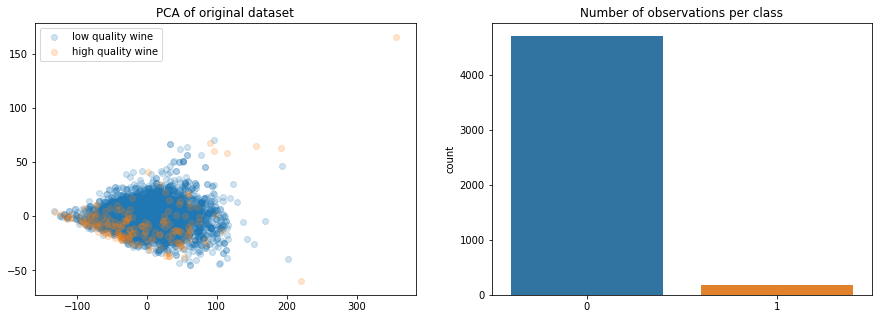

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.decomposition import PCA
import seaborn as sns

# Reduce dataset to 2 feature dimensions in order to visualize the data
pca = PCA(n_components=2)
pca.fit(X)
X_reduced = pca.transform(X)

fig, ax = plt.subplots(1, 2, figsize= (15,5))

ax[0].scatter(X_reduced[y == 0, 0], X_reduced[y == 0, 1], label="low quality wine", alpha=0.2)
ax[0].scatter(X_reduced[y == 1, 0], X_reduced[y == 1, 1], label="high quality wine", alpha=0.2)
ax[0].set_title('PCA of original dataset')
ax[0].legend()

ax[1] = sns.countplot(y)
ax[1].set_title('Number of observations per class')

#### Train test split

Separamos el dataset en conjuntos de entrenamiento y test para validar el modelo predictor de la calidad del vino que queremos generar

In [5]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2)

## Pipeline con diferentes métodos para gestionar datos desbalanceados

Utilizaremos el método 'model_resampling_pipeline(...)' para comparar los diferentes métodos de resampling. En concreto, usaremos los siguientes:
- oversampling: RandomOverSampler, SMOTE, ADASYN
- undersampling: RandomUnderSampler, TomekLinks, EditedNearestNeighbours

In [6]:
from sklearn import metrics 
from collections import Counter

from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler, TomekLinks, EditedNearestNeighbours


def model_resampling_pipeline(X_train, 
                              X_test, 
                              y_train, 
                              y_test, 
                              model):
    results = {'ordinary': {},
               'class_weight': {},
               'oversample': {},
               'undersample': {}}
    
    # ------ No balancing ------
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    accuracy = metrics.accuracy_score(y_test, predictions)
    precision, recall, fscore, support = metrics.precision_recall_fscore_support(y_test, predictions)
    tn, fp, fn, tp = metrics.confusion_matrix(y_test, predictions).ravel()
    fpr, tpr, thresholds = metrics.roc_curve(y_test, predictions, pos_label=1)
    auc = metrics.auc(fpr, tpr)
    
    results['ordinary'] = {'accuracy': accuracy, 'precision': precision, 'recall': recall, 
                          'fscore': fscore, 'n_occurences': support,
                          'predictions_count': Counter(predictions),
                          'tp': tp, 'tn': tn, 'fp': fp, 'fn': fn,
                          'auc': auc}
    
    
    # ------ Class weight ------
    if 'class_weight' in model.get_params().keys():
        model.set_params(class_weight='balanced')
        model.fit(X_train, y_train)
        predictions = model.predict(X_test)
        accuracy = metrics.accuracy_score(y_test, predictions)
        precision, recall, fscore, support = metrics.precision_recall_fscore_support(y_test, predictions)
        tn, fp, fn, tp = metrics.confusion_matrix(y_test, predictions).ravel()
        fpr, tpr, thresholds = metrics.roc_curve(y_test, predictions, pos_label=1)
        auc = metrics.auc(fpr, tpr)

        results['class_weight'] = {'accuracy': accuracy, 'precision': precision, 'recall': recall, 
                                  'fscore': fscore, 'n_occurences': support,
                                  'predictions_count': Counter(predictions),
                                  'tp': tp, 'tn': tn, 'fp': fp, 'fn': fn,
                                  'auc': auc}

    
    # ------------ OVERSAMPLING TECHNIQUES ------------
    print('------ Oversampling methods ------')
    techniques = [RandomOverSampler(),
                  SMOTE(),
                  ADASYN()]
    
    for sampler in techniques:
        technique = sampler.__class__.__name__
        print(f'Technique: {technique}')
        print(f'Before resampling: {sorted(Counter(y_train).items())}')
        X_resampled, y_resampled = sampler.fit_sample(X_train, y_train)
        print(f'After resampling: {sorted(Counter(y_resampled).items())}')

        model.fit(X_resampled, y_resampled)
        predictions = model.predict(X_test)
        accuracy = metrics.accuracy_score(y_test, predictions)
        precision, recall, fscore, support = metrics.precision_recall_fscore_support(y_test, predictions)
        tn, fp, fn, tp = metrics.confusion_matrix(y_test, predictions).ravel()
        fpr, tpr, thresholds = metrics.roc_curve(y_test, predictions, pos_label=1)
        auc = metrics.auc(fpr, tpr)

        results['oversample'][technique] = {'accuracy': accuracy, 
                                            'precision': precision, 
                                            'recall': recall,
                                            'fscore': fscore, 
                                            'n_occurences': support,
                                            'predictions_count': Counter(predictions),
                                            'tp': tp, 'tn': tn, 'fp': fp, 'fn': fn,
                                            'auc': auc}

    
    # ------------ UNDERSAMPLING TECHNIQUES ------------
    print('------ Undersampling methods ------')
    techniques = [RandomUnderSampler(),                  
                  TomekLinks(),
                  EditedNearestNeighbours()]
    
    for sampler in techniques:
        technique = sampler.__class__.__name__
        print(f'Technique: {technique}')
        print(f'Before resampling: {sorted(Counter(y_train).items())}')
        X_resampled, y_resampled = sampler.fit_sample(X_train, y_train)
        print(f'After resampling: {sorted(Counter(y_resampled).items())}')

        model.fit(X_resampled, y_resampled)
        predictions = model.predict(X_test)
        accuracy = metrics.accuracy_score(y_test, predictions)
        precision, recall, fscore, support = metrics.precision_recall_fscore_support(y_test, predictions)
        tn, fp, fn, tp = metrics.confusion_matrix(y_test, predictions).ravel()
        fpr, tpr, thresholds = metrics.roc_curve(y_test, predictions, pos_label=1)
        auc = metrics.auc(fpr, tpr)

        results['undersample'][technique] = {'accuracy': accuracy, 
                                            'precision': precision, 
                                            'recall': recall,
                                            'fscore': fscore, 
                                            'n_occurences': support,
                                            'predictions_count': Counter(predictions),
                                            'tp': tp, 'tn': tn, 'fp': fp, 'fn': fn,
                                            'auc': auc}
        

    return results

Using TensorFlow backend.


## Visualización de resultados

Con el objetivo de evaluar visualmente los resultados obtenidos por los modelos que vamos a aplicar, definimos la función 'evaluate_method(...)' 

In [7]:
def evaluate_method(results, 
                    method, 
                    metrics = ['precision', 'recall', 'fscore']):
    fig, ax = plt.subplots(1, 7, sharey=True, figsize=(16, 6))
    
    for i, metric in enumerate(metrics):
        ax[i*2].axhline(results['ordinary'][metric][0], label='No Resampling')
        ax[i*2+1].axhline(results['ordinary'][metric][1], label='No Resampling')
        
        if results['class_weight']:
            ax[i*2].bar(0, results['class_weight'][metric][0], label='Adjust Class Weight')
            ax[i*2+1].bar(0, results['class_weight'][metric][1], label='Adjust Class Weight')
            
        ax[0].legend(loc='upper center', bbox_to_anchor=(9, 1.01),
                     ncol=1, fancybox=True, shadow=True)
        
        for j, (technique, result) in enumerate(results[method].items()):
            ax[i*2].bar(j+1, result[metric][0], label=technique)
            
            ax[i*2+1].bar(j+1, result[metric][1], label=technique)
        
        
        ax[i*2].set_title(f'Low quality wine: \n{metric}')
        ax[i*2+1].set_title(f'High quality wine: \n{metric}')
    
    # AUC vis
    ax[6].set_title(f'Area under curve')
    ax[6].axhline(results['ordinary']['auc'], label='No Resampling')
    if results['class_weight']:
        ax[6].bar(0, results['class_weight']['auc'], label='Adjust Class Weight')
    for j, (technique, result) in enumerate(results[method].items()):
        ax[6].bar(j+1, result['auc'], label=technique)

# Modelos de aprendizaje

Aplicaremos unos modelos supervisados sencillos, los vistos en clase:
- Árboles de decisión: DecisionTreeClassifier
- kNN: KNeighborsClassifier
- Redes neuronales: MLPClassifier

In [8]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

## Árboles de decisión

Visualizar un árbol de decisión entrenado con datos desbalanceados

In [9]:
model = DecisionTreeClassifier(max_depth=4)
model.fit(X_train, y_train)

from IPython.display import Image  
from sklearn.externals.six import StringIO  
import pydot  
from sklearn import tree

#dot_data = StringIO()  
#tree.export_graphviz(model, out_file=dot_data)
#graph = pydot.graph_from_dot_data(dot_data.getvalue())  
#Image(graph[0].create_png())

In [10]:
model = DecisionTreeClassifier()
results = model_resampling_pipeline(X_train, X_test, y_train, y_test, model)

------ Oversampling methods ------
Technique: RandomOverSampler
Before resampling: [(0, 3772), (1, 146)]
After resampling: [(0, 3772), (1, 3772)]
Technique: SMOTE
Before resampling: [(0, 3772), (1, 146)]
After resampling: [(0, 3772), (1, 3772)]
Technique: ADASYN
Before resampling: [(0, 3772), (1, 146)]
After resampling: [(0, 3772), (1, 3749)]
------ Undersampling methods ------
Technique: RandomUnderSampler
Before resampling: [(0, 3772), (1, 146)]
After resampling: [(0, 146), (1, 146)]
Technique: TomekLinks
Before resampling: [(0, 3772), (1, 146)]
After resampling: [(0, 3726), (1, 146)]
Technique: EditedNearestNeighbours
Before resampling: [(0, 3772), (1, 146)]
After resampling: [(0, 3515), (1, 146)]


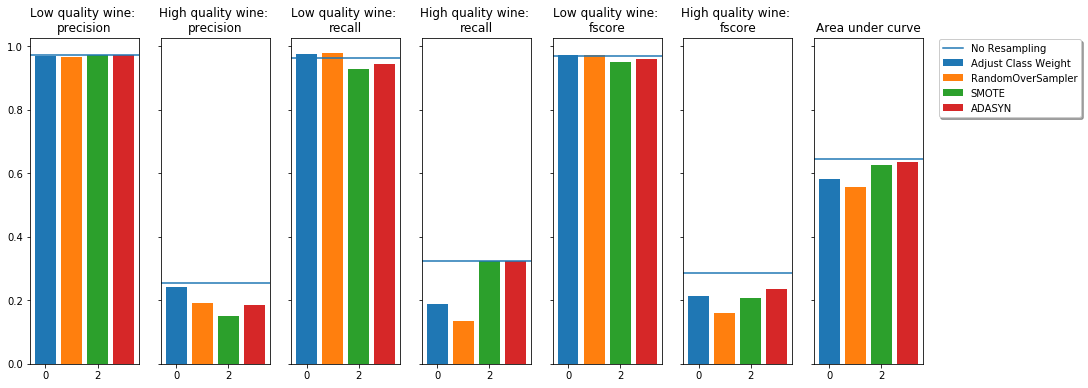

In [11]:
evaluate_method(results, 'oversample')

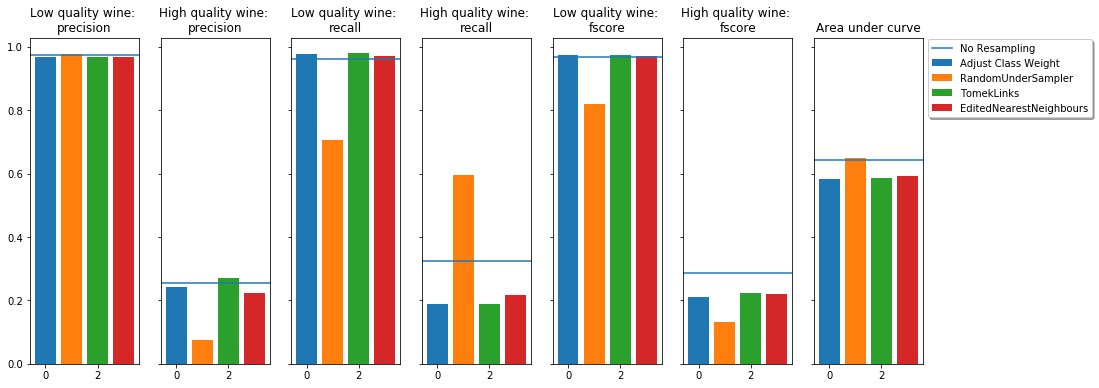

In [12]:
evaluate_method(results, 'undersample')

## kNN

In [13]:
model = KNeighborsClassifier()
results = model_resampling_pipeline(X_train, X_test, y_train, y_test, model)

------ Oversampling methods ------
Technique: RandomOverSampler
Before resampling: [(0, 3772), (1, 146)]
After resampling: [(0, 3772), (1, 3772)]
Technique: SMOTE
Before resampling: [(0, 3772), (1, 146)]
After resampling: [(0, 3772), (1, 3772)]
Technique: ADASYN
Before resampling: [(0, 3772), (1, 146)]
After resampling: [(0, 3772), (1, 3749)]
------ Undersampling methods ------
Technique: RandomUnderSampler
Before resampling: [(0, 3772), (1, 146)]
After resampling: [(0, 146), (1, 146)]
Technique: TomekLinks
Before resampling: [(0, 3772), (1, 146)]
After resampling: [(0, 3726), (1, 146)]
Technique: EditedNearestNeighbours
Before resampling: [(0, 3772), (1, 146)]
After resampling: [(0, 3515), (1, 146)]


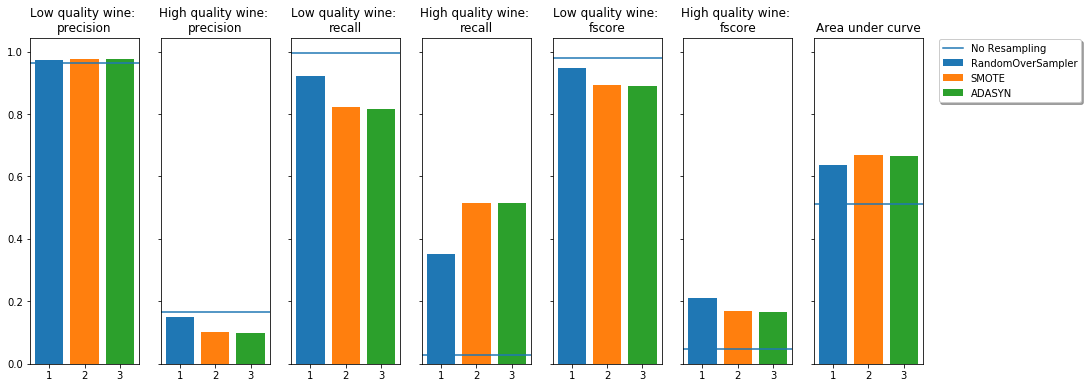

In [14]:
evaluate_method(results, 'oversample')

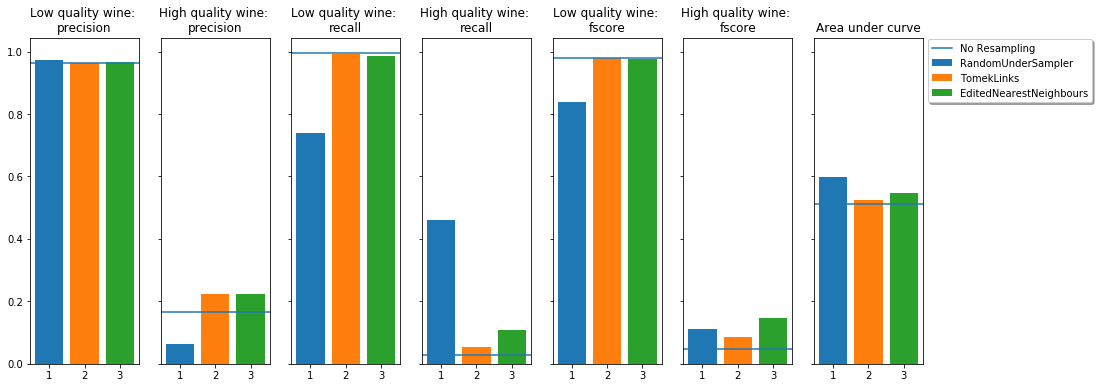

In [15]:
evaluate_method(results, 'undersample')

## Redes neuronales

In [16]:
model = MLPClassifier(hidden_layer_sizes=(50, 50), activation='relu', solver='sgd')
results = model_resampling_pipeline(X_train, X_test, y_train, y_test, model)

------ Oversampling methods ------
Technique: RandomOverSampler
Before resampling: [(0, 3772), (1, 146)]
After resampling: [(0, 3772), (1, 3772)]
Technique: SMOTE
Before resampling: [(0, 3772), (1, 146)]
After resampling: [(0, 3772), (1, 3772)]
Technique: ADASYN
Before resampling: [(0, 3772), (1, 146)]
After resampling: [(0, 3772), (1, 3749)]
------ Undersampling methods ------
Technique: RandomUnderSampler
Before resampling: [(0, 3772), (1, 146)]
After resampling: [(0, 146), (1, 146)]
Technique: TomekLinks
Before resampling: [(0, 3772), (1, 146)]
After resampling: [(0, 3726), (1, 146)]
Technique: EditedNearestNeighbours
Before resampling: [(0, 3772), (1, 146)]
After resampling: [(0, 3515), (1, 146)]


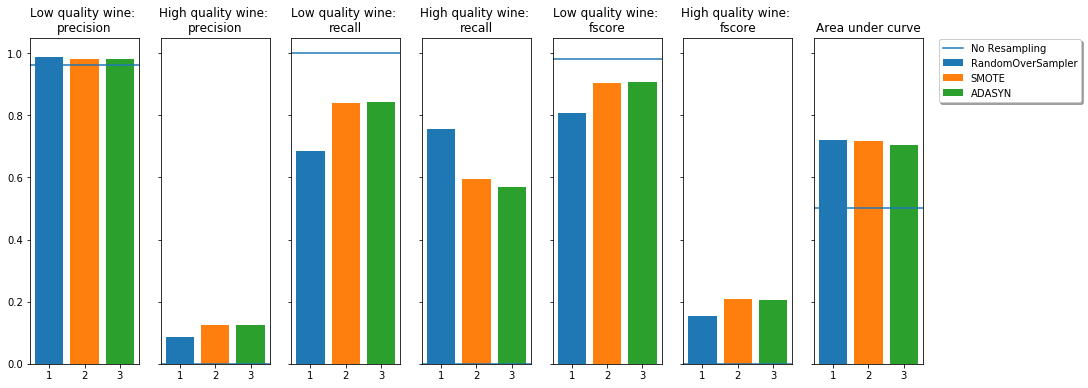

In [17]:
evaluate_method(results, 'oversample')

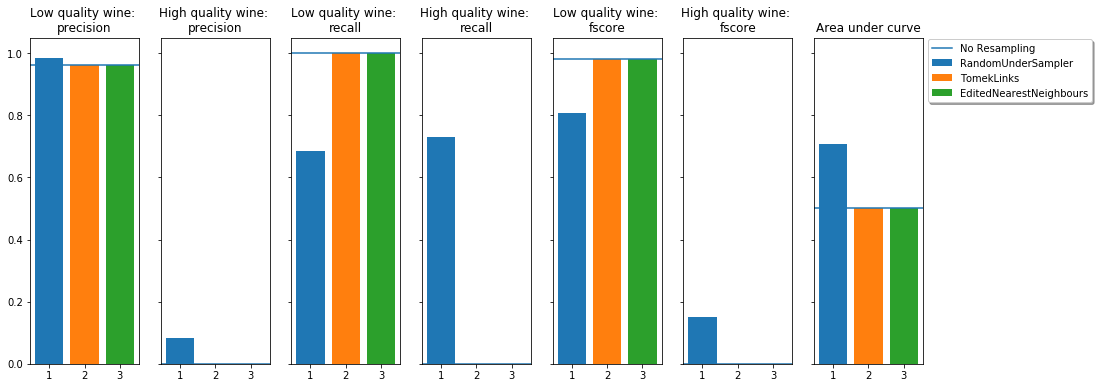

In [18]:
evaluate_method(results, 'undersample')

# Ejercicio 1

### Hacer lo mismo utilizando otro dataset y comentar resultados

Cargar los datos que vamos a trabajar sobre el índice de crimen en US. 
Están disponibles en http://archive.ics.uci.edu/ml/datasets/communities+and+crime

In [19]:
# US crime dataset contains 100 features, descriptions found here: 
# Target class derived as target: >0.65
df = pd.read_csv('communities.csv')
df.head()

,0,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,target
0,0.19,0.33,0.02,0.90,0.12,0.17,0.34,0.47,0.29,0.32,...,0.12,0.42,0.50,0.51,0.64,0.12,0.26,0.20,0.32,-1
1,0.00,0.16,0.12,0.74,0.45,0.07,0.26,0.59,0.35,0.27,...,0.21,0.50,0.34,0.60,0.52,0.02,0.12,0.45,0.00,1
2,0.00,0.42,0.49,0.56,0.17,0.04,0.39,0.47,0.28,0.32,...,0.14,0.49,0.54,0.67,0.56,0.01,0.21,0.02,0.00,-1
3,0.04,0.77,1.00,0.08,0.12,0.10,0.51,0.50,0.34,0.21,...,0.19,0.30,0.73,0.64,0.65,0.02,0.39,0.28,0.00,-1
4,0.01,0.55,0.02,0.95,0.09,0.05,0.38,0.38,0.23,0.36,...,0.11,0.72,0.64,0.61,0.53,0.04,0.09,0.02,0.00,-1


Preparamos los datos, separando variables predictoras, en X, y variable objetivo a predecir, y

In [20]:
X, y = df.values[:,:-1], df.values[:,-1]
print(np.unique(y))
# pasamos los valores de y número entero {0,1}
y = (y==1).astype(int)

[-1.  1.]


#### Visualizar el dataset

Así comprobamos visualmente la distribución de cada valor de clase y podemos apreciar claramente la naturaleza desbalanceada del dataset. Para ello, aplicamos una técnica de reducción de dimensionalidad, PCA, quedándonos con los 2 primeros componentes principales para una visualización óptima

Text(0.5, 1.0, 'Number of observations per class')

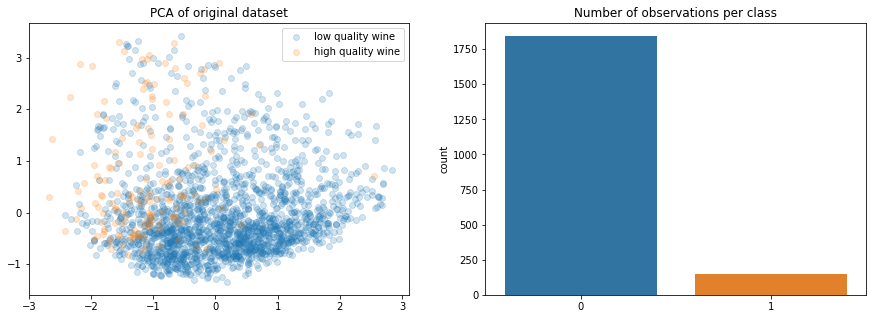

In [21]:
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.decomposition import PCA
import seaborn as sns

# Reduce dataset to 2 feature dimensions in order to visualize the data
pca = PCA(n_components=2)
pca.fit(X)
X_reduced = pca.transform(X)

fig, ax = plt.subplots(1, 2, figsize= (15,5))

ax[0].scatter(X_reduced[y == 0, 0], X_reduced[y == 0, 1], label="low quality wine", alpha=0.2)
ax[0].scatter(X_reduced[y == 1, 0], X_reduced[y == 1, 1], label="high quality wine", alpha=0.2)
ax[0].set_title('PCA of original dataset')
ax[0].legend()

ax[1] = sns.countplot(y)
ax[1].set_title('Number of observations per class')

#### Train test split

Separamos el dataset en conjuntos de entrenamiento y test para validar el modelo predictor de la calidad del vino que queremos generar

In [22]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2)

## Se utiliza el Pipeline definido anteriormente: model_resampling_pipeline()

## Visualización de resultados: evaluate_method()

# Modelos de aprendizaje

Aplicaremos unos modelos supervisados sencillos, los vistos en clase:
- Árboles de decisión: DecisionTreeClassifier
- kNN: KNeighborsClassifier
- Redes neuronales: MLPClassifier

In [23]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

## Árboles de decisión

Visualizar un árbol de decisión entrenado con datos desbalanceados

In [25]:
model = DecisionTreeClassifier(max_depth=4)
model.fit(X_train, y_train)

from IPython.display import Image  
from sklearn.externals.six import StringIO  
import pydot  
from sklearn import tree

#dot_data = StringIO()  
#tree.export_graphviz(model, out_file=dot_data)
#graph = pydot.graph_from_dot_data(dot_data.getvalue())  
#Image(graph[0].create_png())

In [26]:
model = DecisionTreeClassifier()
results = model_resampling_pipeline(X_train, X_test, y_train, y_test, model)

------ Oversampling methods ------
Technique: RandomOverSampler
Before resampling: [(0, 1475), (1, 120)]
After resampling: [(0, 1475), (1, 1475)]
Technique: SMOTE
Before resampling: [(0, 1475), (1, 120)]
After resampling: [(0, 1475), (1, 1475)]
Technique: ADASYN
Before resampling: [(0, 1475), (1, 120)]
After resampling: [(0, 1475), (1, 1465)]
------ Undersampling methods ------
Technique: RandomUnderSampler
Before resampling: [(0, 1475), (1, 120)]
After resampling: [(0, 120), (1, 120)]
Technique: TomekLinks
Before resampling: [(0, 1475), (1, 120)]
After resampling: [(0, 1459), (1, 120)]
Technique: EditedNearestNeighbours
Before resampling: [(0, 1475), (1, 120)]
After resampling: [(0, 1350), (1, 120)]


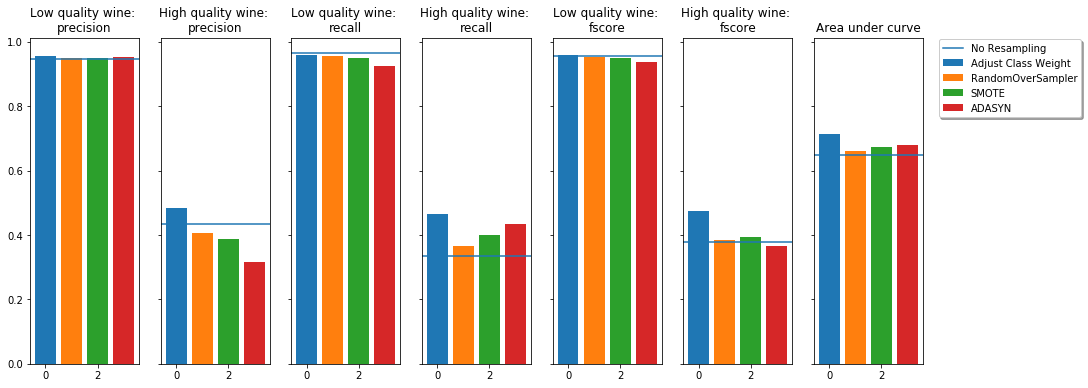

In [27]:
evaluate_method(results, 'oversample')

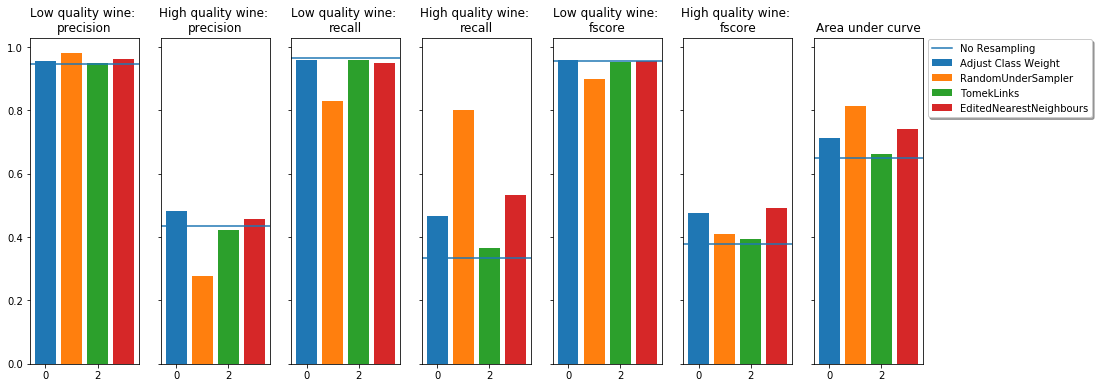

In [28]:
evaluate_method(results, 'undersample')

## kNN

In [29]:
model = KNeighborsClassifier()
results = model_resampling_pipeline(X_train, X_test, y_train, y_test, model)

------ Oversampling methods ------
Technique: RandomOverSampler
Before resampling: [(0, 1475), (1, 120)]
After resampling: [(0, 1475), (1, 1475)]
Technique: SMOTE
Before resampling: [(0, 1475), (1, 120)]
After resampling: [(0, 1475), (1, 1475)]
Technique: ADASYN
Before resampling: [(0, 1475), (1, 120)]
After resampling: [(0, 1475), (1, 1465)]
------ Undersampling methods ------
Technique: RandomUnderSampler
Before resampling: [(0, 1475), (1, 120)]
After resampling: [(0, 120), (1, 120)]
Technique: TomekLinks
Before resampling: [(0, 1475), (1, 120)]
After resampling: [(0, 1459), (1, 120)]
Technique: EditedNearestNeighbours
Before resampling: [(0, 1475), (1, 120)]
After resampling: [(0, 1350), (1, 120)]


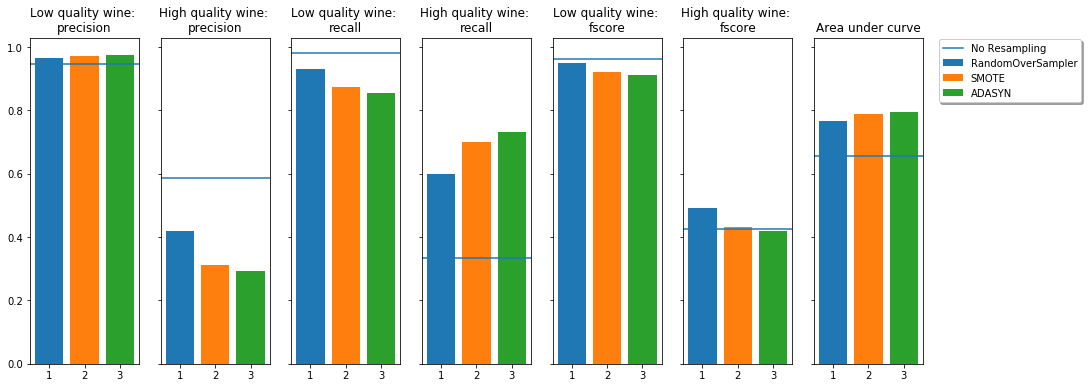

In [30]:
evaluate_method(results, 'oversample')

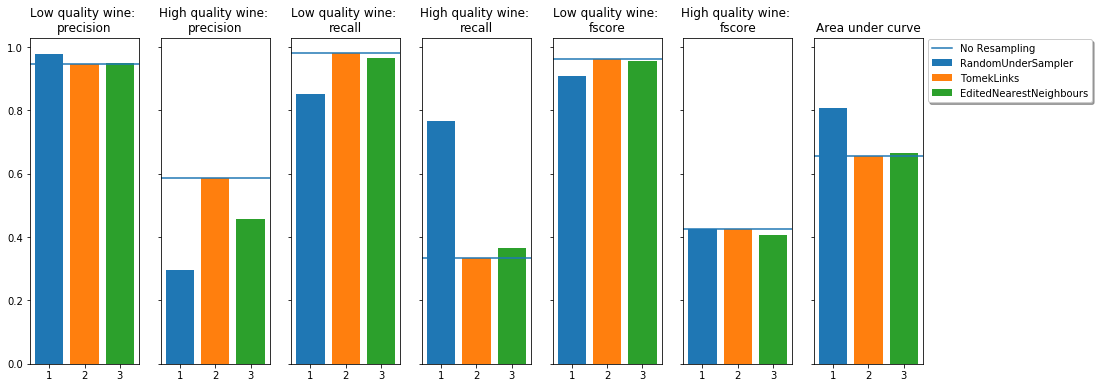

In [31]:
evaluate_method(results, 'undersample')

## Redes neuronales

In [32]:
model = MLPClassifier(hidden_layer_sizes=(50, 50), activation='relu', solver='sgd')
results = model_resampling_pipeline(X_train, X_test, y_train, y_test, model)

------ Oversampling methods ------
Technique: RandomOverSampler
Before resampling: [(0, 1475), (1, 120)]
After resampling: [(0, 1475), (1, 1475)]
Technique: SMOTE
Before resampling: [(0, 1475), (1, 120)]
After resampling: [(0, 1475), (1, 1475)]
Technique: ADASYN
Before resampling: [(0, 1475), (1, 120)]
After resampling: [(0, 1475), (1, 1465)]
------ Undersampling methods ------
Technique: RandomUnderSampler
Before resampling: [(0, 1475), (1, 120)]
After resampling: [(0, 120), (1, 120)]
Technique: TomekLinks
Before resampling: [(0, 1475), (1, 120)]
After resampling: [(0, 1459), (1, 120)]
Technique: EditedNearestNeighbours
Before resampling: [(0, 1475), (1, 120)]
After resampling: [(0, 1350), (1, 120)]


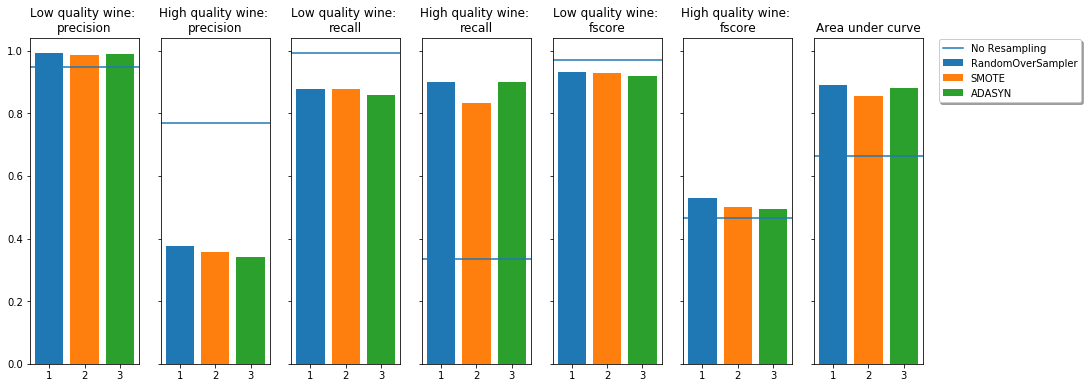

In [33]:
evaluate_method(results, 'oversample')

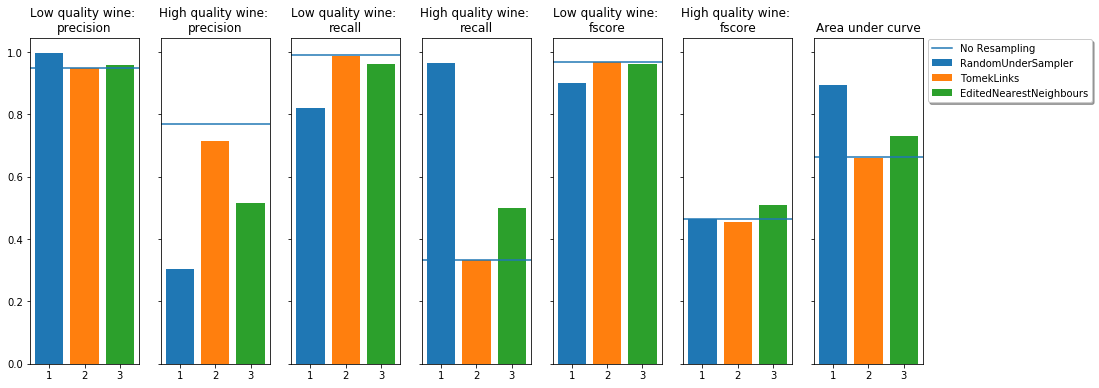

In [34]:
evaluate_method(results, 'undersample')

# Ejercicio 2

### Proponer otro método de aprendizaje supervisado y ver si mejora los resultados obtenidos por los 3 propuestos

### SVM

In [35]:
from sklearn import svm
model = svm.SVC()
results = model_resampling_pipeline(X_train, X_test, y_train, y_test, model)


------ Oversampling methods ------
Technique: RandomOverSampler
Before resampling: [(0, 1475), (1, 120)]
After resampling: [(0, 1475), (1, 1475)]
Technique: SMOTE
Before resampling: [(0, 1475), (1, 120)]
After resampling: [(0, 1475), (1, 1475)]
Technique: ADASYN
Before resampling: [(0, 1475), (1, 120)]
After resampling: [(0, 1475), (1, 1465)]
------ Undersampling methods ------
Technique: RandomUnderSampler
Before resampling: [(0, 1475), (1, 120)]
After resampling: [(0, 120), (1, 120)]
Technique: TomekLinks
Before resampling: [(0, 1475), (1, 120)]
After resampling: [(0, 1459), (1, 120)]
Technique: EditedNearestNeighbours
Before resampling: [(0, 1475), (1, 120)]
After resampling: [(0, 1350), (1, 120)]


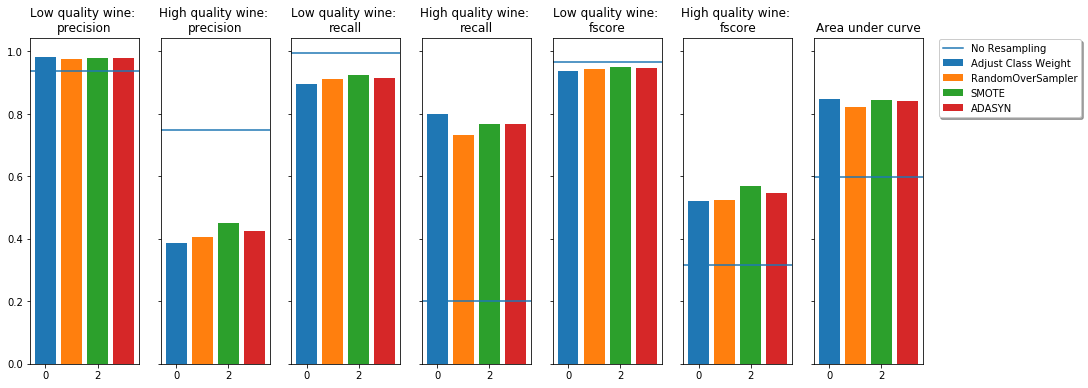

In [36]:
evaluate_method(results, 'oversample')

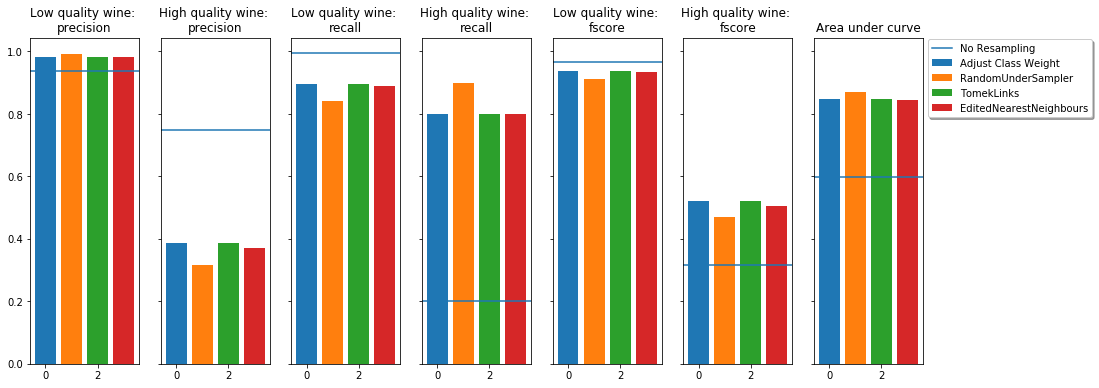

In [37]:
evaluate_method(results, 'undersample')

## Tras comprobar SVM los resultados no mejoran 